In [1]:
#.libPaths(c("/home/data/refdir/Rlib","/home/data/t060324/R/x86_64-pc-linux-gnu-library/4.1"))
library(scibet)
library(Seurat)
library(scater)
library(scran)
library(dplyr)
library(Matrix)
library(cowplot)
library(ggplot2)
library(harmony)
rm(list = ls())
gc()
setwd('/home/data/t060324/jobs/aimin/')

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,7981828,426.3,14808651,790.9,10206884,545.2
Vcells,13716140,104.7,21468864,163.8,17824054,136.0


In [2]:
mergeData_immune <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_immune_final.RDS')

# 1.Construct cell-cell interaction network by integrating bulk data

#### step1:The shared genes of TCGA Bulk and single cell data were extracted for subsequent analysis

In [3]:
TCGA_OV_TPM_log <- readRDS(file = './data/bulk/TCGA_OV_TPM_log2.RDS')
dim(TCGA_OV_TPM_log)

[1] 32936   379

In [4]:
DefaultAssay(mergeData_immune) <- 'RNA'

In [981]:
cellType <- as.character(mergeData_immune$cellType)
names(cellType) <- colnames(mergeData_immune)
cell_list <- split(colnames(mergeData_immune),f = cellType)
sampleCell <- lapply(cell_list,function(x){
    if(length(x)<400){
        subsample <- x
    }else{
        subsample <- sample(x = x,size = 400,replace = F)
    }
 return(subsample)
})
sampleCell <- do.call(c,sampleCell)

In [982]:
mergeData_immune_sub <- subset(x =mergeData_immune,cells =  sampleCell)

In [983]:
suppressMessages(library(ggplot2))
suppressMessages(library(tidyverse))
suppressMessages(library(scibet))
suppressMessages(library(viridis))
suppressMessages(library(ggsci))
expr <- t(as.matrix(mergeData_immune_sub@assays$RNA@data))
expr <- as.data.frame(expr)
expr$label <- mergeData_immune_sub$cellType
etest_gene <- SelectGene(expr = expr,k = 5000)

In [987]:
geneboth <- intersect(rownames(TCGA_OV_TPM_log),etest_gene)
length(geneboth)

[1] 4884

In [1000]:
saveRDS(geneboth,file = './output/1.sangleCell_pre/cell2celluseGene.RDS')

In [5]:
geneboth <- readRDS(file = './output/1.sangleCell_pre/cell2celluseGene.RDS')

#### step2: Fisher’s exact test identifies genes that are expressed specifically by cell types

In [991]:
gene_fisher <- function(data=GSE183904_merge_224,Subcluster='Subcluster',assays='RNA',solt='counts',gene=node$name,cellTpye="Fibroblast",exp_cutoff=0){
            fibcell <- c(data@meta.data[,Subcluster] %in% cellTpye)
            n.cell <- ncol(data)
            dataExp <- GetAssayData(data,assay = assays,slot = solt)
            #gene <- intersect(gene,rownames(data))
            res.geneFisher <- lapply(gene,function(i){
                if(i=='CCN2'){
                    j='CTGF'
                }
                if(i=='CCN1'){
                    j='CYR61'
                }else{
                    j=i
                }
                if(j %in% rownames(data)){
                
                cell_expGene <- c(dataExp[j,]>exp_cutoff)
                a11 <- sum(fibcell * cell_expGene)
                a12 <- sum(cell_expGene)- a11
                a21 <- sum(fibcell)- a11
                a22 <- n.cell - a12 - a21 - a11
               fisher_matrix <- matrix(c(a11,
                              a12,
                              a21,
                              a22),
                              nrow=2)
                res <- fisher.test(fisher_matrix,alternative='greater')   
                
                res.data <- data.frame(gene=i,cellType=cellTpye,OR=0,P=0,P.adjust=0,number_of_cell_expGene=0,Proportion=0)
                res.data$OR[1] <- as.vector(res[[3]])
                res.data$P[1] <- as.vector(res[[1]])
                res.data$P.adjust[1] <- as.vector(res[[1]])
                res.data$number_of_cell_expGene[1] <- fisher_matrix[1]
                #fisher[i,'Proportion'] <- fisher_matrix[1]/(fisher_matrix[1]+fisher_matrix[2])  
                res.data$Proportion[1] <- fisher_matrix[1]/sum(fibcell)
                }else{
                   res.data <- data.frame(gene=i,cellType=cellTpye,OR=NA,P=NA,P.adjust=NA,number_of_cell_expGene=NA,Proportion=NA)     
                }
                return(res.data)
            })
    if(length(res.geneFisher)>1){
           res.geneFisher <- do.call(rbind,res.geneFisher)
           res.geneFisher$P.adjust <- p.adjust(res.geneFisher$P,n = length(res.geneFisher$P))
    }else{
       res.geneFisher <-  res.geneFisher[[1]]
    }

    return(res.geneFisher)
}


In [821]:
s=Sys.time()
test <- gene_fisher(data = mergeData_immune,Subcluster = 'cellType',gene = geneboth[1:10],cellTpye = 'B cell')

e=Sys.time()

print(e-s)


Time difference of 4.471301 secs


In [992]:
library(parallel)
cl <- makeCluster(8)

In [993]:
clusterExport(cl, varlist = c('gene_fisher','mergeData_immune','geneboth'))  # add other objects needed

In [994]:
clusterEvalQ(cl,{.libPaths(c("/home/data/refdir/Rlib","/home/data/t060324/R/x86_64-pc-linux-gnu-library/4.1"))
    library('Seurat')})

[[1]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[2]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[3]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[4]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[5]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[6]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[7]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[8]]
 [1] "sp"           "SeuratObject" "Seurat"       "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"

In [995]:
gene_fisher_list <- parLapply(cl = cl,X = unique(mergeData_immune$cellType),fun = function(celltype){
    print(celltype)
    return(gene_fisher(data = mergeData_immune,Subcluster = 'cellType',gene = geneboth,cellTpye = celltype))
})

In [996]:
names(gene_fisher_list) <- unique(mergeData_immune$cellType)

In [997]:
head(gene_fisher_list$`CD8+Tex`)

,gene,cellType,OR,P,P.adjust,number_of_cell_expGene,Proportion
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A2M,CD8+Tex,0.09024555,1.000000e+00,1.000000e+00,57,0.0231425091
2,A4GALT,CD8+Tex,0.01719840,1.000000e+00,1.000000e+00,2,0.0008120179
3,AAED1,CD8+Tex,0.37678538,1.000000e+00,1.000000e+00,218,0.0885099472
4,AAK1,CD8+Tex,1.62828276,3.828364e-32,1.740757e-28,1119,0.4543239951
5,AAMDC,CD8+Tex,0.21486318,1.000000e+00,1.000000e+00,89,0.0361347950
6,AAMP,CD8+Tex,0.60092075,1.000000e+00,1.000000e+00,318,0.1291108404


In [998]:
stopCluster(cl)

In [999]:
saveRDS(gene_fisher_list,file = './output/1.sangleCell_pre/OV_mergeData_immuneCell_geneFisher_list.RDS')

In [6]:
gene_fisher_list <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_immuneCell_geneFisher_list.RDS')

### step3:Identify cell Abundance related genes

In [9]:
## 以单细胞数据做参考，CIBERSORTx方法估算细胞浸润丰度
CIBERSORTx_immuneCell <- read.csv('/home/data/t060324/jobs/aimin/data/bulk/CIBERSORTx_mergeData2.csv',header = T,sep = ',')
rownames(CIBERSORTx_immuneCell) <- CIBERSORTx_immuneCell$Mixture
CIBERSORTx_immuneCell <- CIBERSORTx_immuneCell[,2:34]
colnames(CIBERSORTx_immuneCell) <- c('B cell','CAF1','CAF2','CAF3','CAF4','CAF5','CD38+NK','CD8+Te','CD8+Tem',
                                     'CD8+Tex','CD8+Tn','CD8+TpreEx','cDC1','cDC2','Endo','ISG+CD8T','Macro_C1QB','Macro_CCL3L3',
                                     'Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','mast_cell','Mature NK','Mono_FCN1','myCAF','NK','pDC',
                                     'Plasma cell','Tfh','Th17','Tn','Treg')
head(CIBERSORTx_immuneCell)

,B cell,CAF1,CAF2,CAF3,CAF4,CAF5,CD38+NK,CD8+Te,CD8+Tem,CD8+Tex,⋯,Mature NK,Mono_FCN1,myCAF,NK,pDC,Plasma cell,Tfh,Th17,Tn,Treg
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA.23.1120.01A,0.016018656,0.08196585,0.15443041,0.0000000000,0.02621643,0.0000000000,0.026965240,0.06287633,0.000000000,0,⋯,0.00000000,0.00000000,0.02760410,0.002949724,0.035089009,0.00000000,0.009362166,0,0.07770413,0.000000000
TCGA.29.1695.01A,0.036235774,0.52022755,0.05702697,0.0000000000,0.00000000,0.0000000000,0.000000000,0.12663414,0.000000000,0,⋯,0.01313994,0.03261075,0.02354860,0.036000411,0.010470496,0.00000000,0.016881123,0,0.06517424,0.002506389
TCGA.61.2003.01A,0.000000000,0.52167182,0.03186063,0.0000000000,0.12555359,0.0000000000,0.000000000,0.20801299,0.000000000,0,⋯,0.00000000,0.02714180,0.04934227,0.024019638,0.008378977,0.00000000,0.000000000,0,0.09584818,0.019077341
TCGA.13.1404.01A,0.039672250,0.25104132,0.12369059,0.0372685402,0.00000000,0.0000000000,0.022156710,0.10596354,0.001093635,0,⋯,0.00000000,0.00000000,0.02461452,0.002962958,0.027181085,0.05232419,0.006046231,0,0.09397477,0.014542763
TCGA.23.1027.01A,0.011086760,0.30488336,0.14419757,0.0004712983,0.00000000,0.0001075459,0.001361755,0.08530078,0.013454454,0,⋯,0.00000000,0.00000000,0.00000000,0.003999559,0.012112269,0.00000000,0.010433680,0,0.08204756,0.008685669
TCGA.23.1022.01A,0.001259467,0.00000000,0.28058152,0.0000000000,0.00699572,0.0000000000,0.000000000,0.05572791,0.008531318,0,⋯,0.00000000,0.00000000,0.03371619,0.046173993,0.032643722,0.00000000,0.006834421,0,0.18028401,0.006606814


In [10]:
TCGA_exp <- TCGA_OV_TPM_log[geneboth,]

In [11]:
all(rownames(CIBERSORTx_immuneCell)==colnames(TCGA_exp))

[1] TRUE

#####  self-expressed genes
* OR>2.5 & expression in more than 30% indicates the gene is expressed in this cell type
* OR>3 and expression in more than 60% of cells indicates that this gene can be used as a marker for this cell type

In [ ]:
gene_fisher_list <- lapply(gene_fisher_list,function(x){
    x$specificity <- ifelse(x$OR>2.5 & x$Proportion>0.3,'expressed','unexpressed')
    x$ismarker <- ifelse(x$Proportion>0.6 & x$OR>3,1,0)
    x <- subset(x,gene %in% geneboth)
    return(x)
})

In [159]:
sapply(gene_fisher_list,function(x){
    table(x$ismarker)
})


,B cell,pDC,Plasma cell,Th17,NK,Tfh,CD8+Tem,Tn,CD8+TpreEx,CD8+Te,⋯,Macro_CXCL10,Macro_MT1H,Macro_MARCO,CAF3,CAF1,CAF4,myCAF,CAF2,CAF5,Endo
0,4811,4778,4877,4874,4866,4867,4870,4859,4865,4852,⋯,4661,4738,4589,4502,4629,3389,4635,4551,3411,4179
1,73,106,7,10,18,17,14,25,19,32,⋯,223,146,295,382,255,1495,249,333,1473,705


In [135]:
cellMarker <- sapply(gene_fisher_list,function(x){
   subset(x,ismarker==1)$gene
})


In [137]:
gene2CellType <- cor(x = CIBERSORTx_immuneCell,y = t(TCGA_exp))

Warning message in cor(x = CIBERSORTx_immuneCell, y = t(TCGA_exp)):
“the standard deviation is zero”


* All genes were correlated with cell abundance calculations by Pearson correlation
* Modified correlation coefficient of self-expressed genes (cor of genes expressed in the corresponding cell type is modified to 0)
* Sort the corrected correlation vector

In [160]:
cellcorGene_list <- list()
for(cellType in names(gene_fisher_list)){
     print(cellType)
    cellcorGene_array <- gene2CellType[cellType,]
    geneExp_forCellType <- gene_fisher_list[[cellType]]
    expressedGene <- subset(geneExp_forCellType,specificity=='expressed')$gene
    cellcorGene_array[expressedGene] <- 0
    cellcorGene_list[[cellType]] <- sort(cellcorGene_array,decreasing = T)
}

[1] "B cell"
[1] "pDC"
[1] "Plasma cell"
[1] "Th17"
[1] "NK"
[1] "Tfh"
[1] "CD8+Tem"
[1] "Tn"
[1] "CD8+TpreEx"
[1] "CD8+Te"
[1] "CD8+Tex"
[1] "Treg"
[1] "Mature NK"
[1] "ISG+CD8T"
[1] "CD8+Tn"
[1] "CD38+NK"
[1] "cDC2"
[1] "Macro_C1QB"
[1] "Mono_FCN1"
[1] "Macro_CCL3L3"
[1] "mast_cell"
[1] "cDC1"
[1] "Macro_SPP1"
[1] "Macro_CXCL10"
[1] "Macro_MT1H"
[1] "Macro_MARCO"
[1] "CAF3"
[1] "CAF1"
[1] "CAF4"
[1] "myCAF"
[1] "CAF2"
[1] "CAF5"
[1] "Endo"


In [161]:
names(cellcorGene_list) <- names(gene_fisher_list)

* The top 20 genes were extracted to construct the cell type enrichment score

In [162]:
Top20_list <- lapply(cellcorGene_list,function(x){
   x= x[which(x>0.25)]
    if(length(x)<20){
        return(names(x))
    }else{
        return(names(x[1:20]))
    }
    
})

In [164]:
saveRDS(Top20_list,file = './output/1.sangleCell_pre/Top20_list.RDS')

In [165]:
Top20_list <- readRDS(file = './output/1.sangleCell_pre/Top20_list.RDS')

In [166]:
Top20_list

$`B cell`
 [1] "LAX1"      "CD27"      "SLAMF7"    "SLAMF1"    "SLAMF6"    "MZB1"     
 [7] "SLFN12L"   "TRAF3IP3"  "SP140"     "IKZF3"     "CD38"      "ITGAL"    
[13] "IGHG3"     "IGHGP"     "ICOS"      "ITK"       "LINC00861" "CCR5"     
[19] "CD40LG"    "CXCR3"    

$pDC
 [1] "MLF1"     "AP3M2"    "ELAVL1"   "ANP32E"   "NAP1L4"   "TMEM189" 
 [7] "UBE2V2"   "CDKN2D"   "ATP5IF1"  "TECR"     "MSI2"     "TFG"     
[13] "ATP6V1H"  "SOX17"    "PHACTR4"  "C12orf65" "UBE2S"    "SSBP3"   
[19] "PBX4"     "CMSS1"   

$`Plasma cell`
 [1] "SLAMF1"     "ICAM3"      "CD27"       "LY9"        "SLAMF6"    
 [6] "TMEM156"    "RHOH"       "P2RY10"     "CXCL9"      "CXCL13"    
[11] "SH2D1A"     "SIT1"       "CXCR3"      "TRBC1"      "IKZF3"     
[16] "TRBC2"      "SIRPG"      "AC004585.1" "S1PR4"      "CXCR6"     

$Th17
 [1] "NR4A3"    "HAS1"     "ADAMTS4"  "GEM"      "HBEGF"    "PAPPA"   
 [7] "RGS2"     "C5AR1"    "SERPINE1" "MMP19"    "OSM"      "FOSL1"   
[13] "ADAM19"   "NR4A1"    "RUNX1T1"  "NLRP3"    "ERRFI1"   "DLC1"    
[19] "IL6"      "ITGA5"   

$NK
 [1] "IL16"   "ITK"    "RASAL3" "DOCK2"  "JAML"   "PRDM1"  "P2RY10" "LY9"   
 [9] "IL21R"  "RCSD1"  "GRAP2"  "ITGAL"  "ZEB2"   "THEMIS" "FLI1"   "CD84"  
[17] "NLRP3"  "MIAT"   "DOCK10" "TRAF1" 

$Tfh
 [1] "TNFRSF13B" "MS4A1"     "LY9"       "LINC00861" "P2RY10"    "SLAMF6"   
 [7] "SLAMF7"    "CCR7"      "SLFN12L"   "CXCL9"     "THEMIS"    "IRF4"     
[13] "EOMES"     "LAX1"      "CD8A"      "TMEM156"   "IL21R"     "FCRL5"    
[19] "TBX21"     "ZAP70"    

$`CD8+Tem`
character(0)

$Tn
 [1] "CCNB1IP1" "SNHG7"    "ATP5MC2"  "COLEC11"  "CFAP36"   "DPCD"    
 [7] "MYL6B"    "MORN2"    "ID4"      "FXYD1"    "UBXN8"    "IFT22"   
[13] "C12orf10" "SMIM26"   "TPPP3"    "EBPL"     "PITPNC1"  "SUPT3H"  
[19] "IMPDH2"   "ERGIC3"  

$`CD8+TpreEx`
 [1] "DCHS1"    "TIMP3"    "DLC1"     "PRKG1"    "FRMD6"    "VGLL3"   
 [7] "ADAMTS12" "HIC1"     "FBN1"     "SEPT11"   "SH3PXD2B" "PDGFRB"  
[13] "LAMB1"    "NUAK1"    "BMP2"     "NAV1"     "TCF4"     "LRP1"    
[19] "LSAMP"    "PTGIS"   

$`CD8+Te`
 [1] "SIRPG"   "KLRB1"   "SLAMF1"  "LST1"    "SH2D1A"  "CXCL9"   "NCR3"   
 [8] "SLAMF6"  "SLAMF7"  "LY9"     "CD27"    "NCF1"    "CCR5"    "TIGIT"  
[15] "TMEM156" "SPN"     "P2RY10"  "SLAMF8"  "S1PR4"   "TESPA1" 

$`CD8+Tex`
 [1] "TRGC1"      "LY9"        "AC004585.1" "CXCL9"      "P2RY10"    
 [6] "STAT4"      "IL21R"      "KLRB1"      "SLAMF7"     "TNFRSF13B" 
[11] "LINC00861"  "ZNF831"     "S1PR4"      "ANKRD22"    "LAX1"      
[16] "LINC00996"  "TMEM156"    "CD40LG"     "ARHGAP15"   "CD5"       

$Treg
 [1] "FCN1"     "NFKBIE"   "CLEC4E"   "BCL2A1"   "GNA15"    "MARCO"   
 [7] "TNF"      "SOD2"     "LST1"     "GPR84"    "NCF1"     "ADAM8"   
[13] "CD1E"     "CD68"     "CCL18"    "CD1C"     "SLC2A6"   "JAML"    
[19] "C15orf48" "NKG7"    

$`Mature NK`
 [1] "VGLL3"    "FAP"      "ADAM12"   "MMP19"    "ADAMTS2"  "ADAMTS12"
 [7] "PRKG1"    "FGF7"     "ITGBL1"   "IL16"     "ALDH1A3"  "FBN1"    
[13] "KCNE4"    "COL5A1"   "C1QTNF6"  "ANTXR2"   "NTM"      "SPARC"   
[19] "MMP2"     "ADAM19"  

$`ISG+CD8T`
 [1] "PARP12"   "ZNFX1"    "DTX3L"    "RABGAP1L" "ZCCHC2"   "SLC15A3" 
 [7] "LGALS3BP" "SP140L"   "APOBEC3A" "MYD88"    "TAP2"     "TRIM25"  
[13] "PRKD2"    "PML"      "UNC93B1"  "GBP3"     "OFD1"     "EFCAB14" 
[19] "UBE2H"    "ARHGAP26"

$`CD8+Tn`
 [1] "KLF4"    "NR4A3"   "DLC1"    "TGFBR1"  "GEM"     "TGFB3"   "LAMB1"  
 [8] "MYO1B"   "FSTL1"   "ERRFI1"  "DCHS1"   "RHOBTB3" "THBD"    "RAPH1"  
[15] "NR4A1"   "LATS2"   "B3GNT5"  "TSC22D2" "ARL5B"   "CHSY1"  

$`CD38+NK`
[1] "HERC6"  "IFIH1"  "IFI27"  "DDX60L"

$cDC2
 [1] "ZNF683"    "C2"        "APOL3"     "PSMB8-AS1" "CTSW"      "NCR3"     
 [7] "LINC01871" "CHI3L1"    "KLRB1"     "TMIGD2"    "XCL2"      "GZMA"     
[13] "TAP2"      "IL2RB"     "KLRC1"     "SELPLG"    "GNLY"      "CD247"    
[19] "CCL5"      "PIK3IP1"  

$Macro_C1QB
 [1] "GIMAP1"   "FLI1"     "BIN2"     "ARHGAP15" "SASH3"    "ARHGAP9" 
 [7] "GNG2"     "JAML"     "GIMAP6"   "SELPLG"   

### step4: Calculation of cell type enrichment score
* The average expression value of genes in each cell type was calculated and Zscore transformation was performed
* For a cell type, the Top 20 genes with high correlation were extracted
* The average expression values of 20 genes in each cell type were calculated as enrichment scores (Escore).


In [169]:
Zscore_Top20 <- lapply(names(Top20_list),FUN = function(x){
    if(length(Top20_list[[x]])>0){
        test <- DotPlot(object = mergeData_immune,features = Top20_list[[x]],group.by = 'cellType')
        Zscore_data <- test$data
        Zscore_data$id <- as.character(Zscore_data$id)
        res <- sapply(X = unique(x = Zscore_data$id), FUN = function(y) {
            data.use <- Zscore_data[Zscore_data$id == 
                y, "avg.exp.scaled"]
                data.use <- mean(x = data.use)
            return(data.use)
        })
    }else{
        res <- rep(0,length(unique(mergeData_immune$cellType)))
        names(res) <- unique(mergeData_immune$cellType)
    }
    return(res)
})




In [170]:
names(Zscore_Top20) <- names(Top20_list)

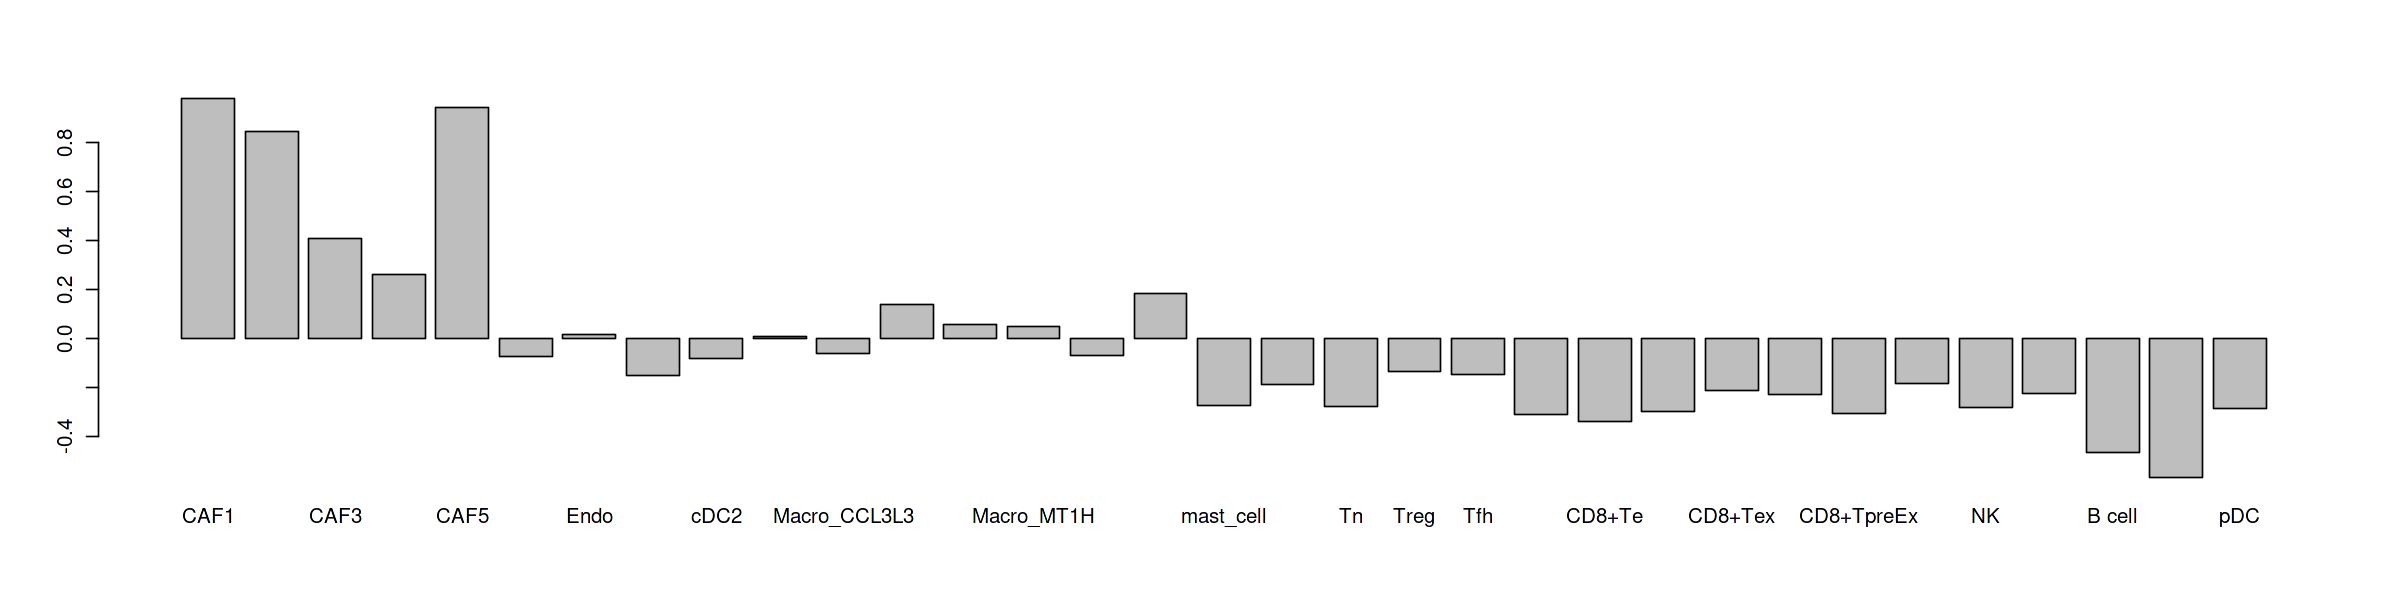

In [260]:
options(repr.plot.height = 5, repr.plot.width = 20)
barplot(height = Zscore_Top20$Macro_SPP1)

### step5:cell-cell interaction networks
* Extraction Escore>1.1 cell type pairs as potential cell-cell interactions

In [287]:
cell2cell <- lapply(names(Zscore_Top20),function(x){
    res <- data.frame(sourceCell=x,targetCell=names(Zscore_Top20[[x]]),Escore=Zscore_Top20[[x]],edge=0)
    res$edge <- ifelse(res$Escore>1.1,1,0)
    return(res)
})
cell2cell <- do.call(rbind,cell2cell)

In [288]:
cell2cell_sub <- subset(cell2cell,edge==1)

In [289]:
names(Zscore_Top20)

[1] "B cell"       "pDC"          "Plasma cell"  "Th17"         "NK"          
 [6] "Tfh"          "CD8+Tem"      "Tn"           "CD8+TpreEx"   "CD8+Te"      
[11] "CD8+Tex"      "Treg"         "Mature NK"    "ISG+CD8T"     "CD8+Tn"      
[16] "CD38+NK"      "cDC2"         "Macro_C1QB"   "Mono_FCN1"    "Macro_CCL3L3"
[21] "mast_cell"    "cDC1"         "Macro_SPP1"   "Macro_CXCL10" "Macro_MT1H"  
[26] "Macro_MARCO"  "CAF3"         "CAF1"         "CAF4"         "myCAF"       
[31] "CAF2"         "CAF5"         "Endo"

In [290]:
cellTypeMapping <- data.frame(lable=names(Zscore_Top20))
cellTypeMapping$Type <- cellTypeMapping$lable
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('Th17','Tn','Treg','Tfh'),'CD4+ T',cellTypeMapping$Type)
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T'),'CD8+ T',cellTypeMapping$Type)
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('NK','Mature NK','CD38+NK'),'NK',cellTypeMapping$Type)
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_SPP1','Mono_FCN1','Macro_MT1H','mast_cell','cDC1','cDC2'),'myeloid',cellTypeMapping$Type)
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('Plasma cell','B cell','pDC'),'B',cellTypeMapping$Type)
cellTypeMapping$Type <- ifelse(cellTypeMapping$lable %in% c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo'),'stroma cell',cellTypeMapping$Type)

In [291]:
cell2cell_sub <- subset(cell2cell_sub,sourceCell!='CD38+NK')
cell2cell_sub <- subset(cell2cell_sub,sourceCell!='CAF2')
cell2cell_sub <- subset(cell2cell_sub,sourceCell!='CAF5')


In [293]:
cellnames <- data.frame(label=c(cell2cell_sub$sourceCell,cell2cell_sub$targetCell) )
nodes<-cellnames%>%
    distinct()
nodes$Type <- NA

for(i in 1:nrow(nodes)){
    nodes[i,'Type']<-cellTypeMapping$Type[which(cellTypeMapping$lable==nodes$label[i])]
}

In [294]:
edges<-cell2cell_sub%>%
    rename(from=sourceCell,to=targetCell,weight=Escore)

In [295]:
edges <- subset(edges,from!=to)

In [299]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col2 <- sample(col_vector,6)

In [300]:
library(igraph)
net_pc<-graph_from_data_frame(
   d=edges,vertices=nodes,
   directed=F)
deg<-degree(net_pc,mode="all")
E(net_pc)$width<-E(net_pc)$weight*3
###设置颜色
vcolor<-cellType_col2
###指定节点的颜色
V(net_pc)$color<-vcolor[factor(V(net_pc)$Type)]

options(repr.plot.height = 10, repr.plot.width = 10)
set.seed(12345)
l <- layout_with_lgl(net_pc)
pdf(file = './output/bulk/section_4/1.cell2cellInteractions_network.pdf',width = 8,height =8)
plot(net_pc,vertex.size=2*deg,
vertex.label.cex=.7,vertex.label.dist=1,layout=l,
edge.color="gray50",edge.arrow.size=.4, edge.curved=.1)
###添加图例
legend(x=-1.3,y=1.2,levels(factor(V(net_pc)$Type)),pch=21,col="#777777",pt.bg=vcolor,border = F)
dev.off()

png 
  2

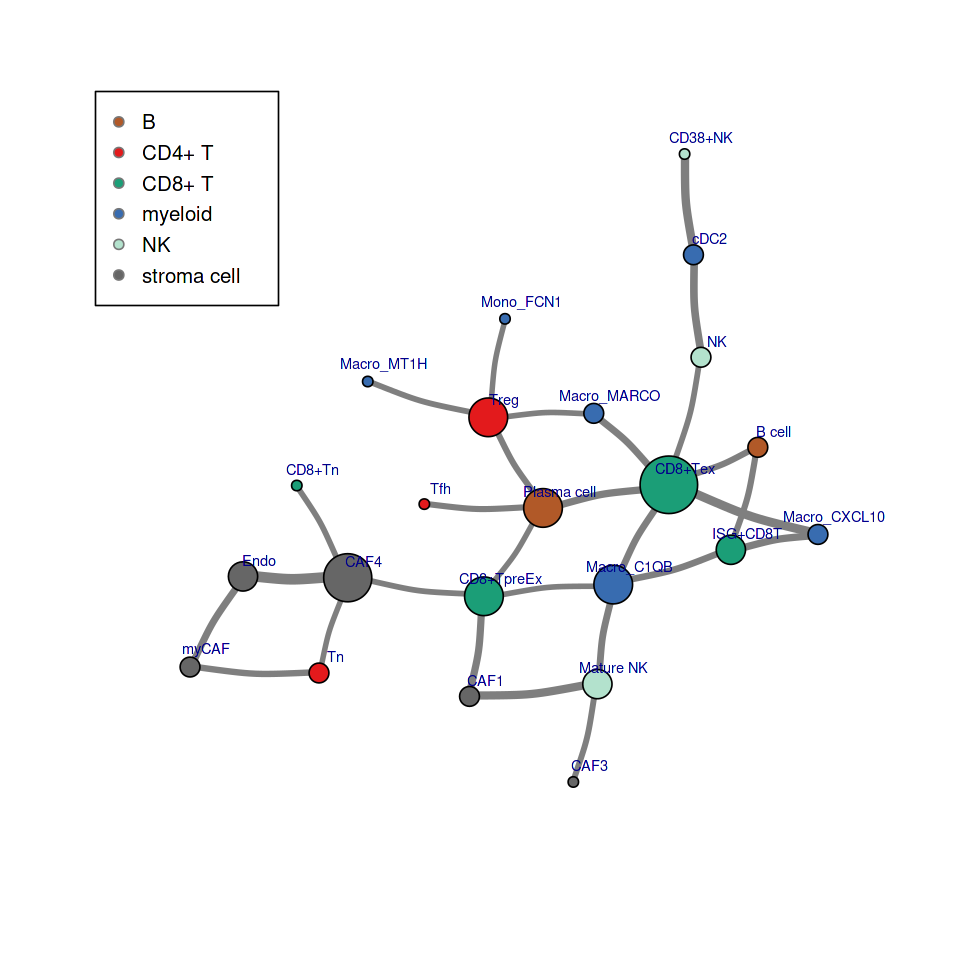

In [301]:
options(repr.plot.height = 8, repr.plot.width = 8)
set.seed(12345)
l <- layout_with_lgl(net_pc)
plot(net_pc,vertex.size=3*deg,
vertex.label.cex=.7,vertex.label.dist=1,layout=l,
edge.color="gray50",edge.arrow.size=.4, edge.curved=.1)
###添加图例
legend(x=-1.3,y=1.2,levels(factor(V(net_pc)$Type)),pch=21,col="#777777",pt.bg=vcolor,border = F)

In [241]:
library(RColorBrewer)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
#处理后有73种差异还比较明显的颜色，基本够用
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
set.seed(seed = 1234)
cellType_col <- sample(col_vector, 5)

In [242]:
cellType_col

[1] "#B15928" "#E31A1C" "#1B9E77" "#386CB0" "#B3E2CD"

In [243]:
names(Top20_list)

[1] "B cell"       "pDC"          "Plasma cell"  "Th17"         "NK"          
 [6] "Tfh"          "CD8+Tem"      "Tn"           "CD8+TpreEx"   "CD8+Te"      
[11] "CD8+Tex"      "Treg"         "Mature NK"    "ISG+CD8T"     "CD8+Tn"      
[16] "CD38+NK"      "cDC2"         "Macro_C1QB"   "Mono_FCN1"    "Macro_CCL3L3"
[21] "mast_cell"    "cDC1"         "Macro_SPP1"   "Macro_CXCL10" "Macro_MT1H"  
[26] "Macro_MARCO"  "CAF3"         "CAF1"         "CAF4"         "myCAF"       
[31] "CAF2"         "CAF5"         "Endo"

## 2.Heatmap characterization of highly associated genes for each cell type

In [244]:
library(ggpubr)

In [245]:
selectCellType <- c('B cell','Plasma cell','Tfh','CD8+Te','CD8+Tex','ISG+CD8T','Macro_C1QB','Macro_CXCL10','Macro_MARCO','Macro_SPP1','CAF4')

In [246]:
library(aplot)
library(ggpubr)

In [302]:
pdf(file = paste0('./output/bulk/section_4/1.corGeneRankCellType.pdf'),width = 8,height =6)
for(x in selectCellType){
gene2CellTypeCor <- gene2CellType[x,Top20_list[[x]]]
gene2CellTypeCor <- data.frame(gene=names(gene2CellTypeCor),cor=gene2CellTypeCor)
cor_p <- ggplot(gene2CellTypeCor,aes(gene,cor))+ 
xlab(NULL) + ylab(label = 'PCC')+ geom_hline(yintercept = 0.5,size=.5,linetype = 2)+
geom_bar(stat="identity",position="identity",width = 0.6)+scale_y_continuous(position = "right",limits = c(0,1))+
ggtitle("")+ theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"),axis.ticks.y = element_blank(),axis.text.y = element_blank())+
guides(fill=guide_legend(title=NULL)) + coord_flip()

cell_EScore <- data.frame(cellType=names(Zscore_Top20[[x]]),Escore=Zscore_Top20[[x]])
cell_EScore$cellType <- as.factor(cell_EScore$cellType)
cell_EScore$cellType <- factor(x = cell_EScore$cellType,
                               levels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                          'Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell','cDC1','cDC2',
                                        'CD38+NK','NK','Mature NK','Tfh','Th17','Treg','Tn','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','B cell','Plasma cell','pDC'),
                                labels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                          'Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell','cDC1','cDC2',
                                        'CD38+NK','NK','Mature NK','Tfh','Th17','Treg','Tn','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','B cell','Plasma cell','pDC') 
                              )
options(repr.plot.height = 5, repr.plot.width = 20)
p1 <- ggbarplot(data = cell_EScore,x = 'cellType',y = 'Escore',fill = 'cellType',legend='None')+
xlab(NULL)+ylim(-1.5,2.1)+ggtitle(paste0('Genes associated with ',x))+geom_hline(yintercept = 1.1, linetype = 2)+
theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"),legend.position="none",axis.ticks.x = element_blank(),axis.text.x = element_blank())
options(repr.plot.height = 10, repr.plot.width = 8)
test5 <- DotPlot(object = mergeData_immune,assay = 'RNA',
        features = Top20_list[[x]],cols = c('blue','red'),group.by = 'cellType')
marker_data  <- test5$data
marker_data$Zscore <- marker_data$avg.exp.scaled
marker_data$cluster <-  marker_data$id
marker_data$cluster <- factor(x = marker_data$cluster,
                               levels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                          'Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell','cDC1','cDC2',
                                        'CD38+NK','NK','Mature NK','Tfh','Th17','Treg','Tn','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','B cell','Plasma cell','pDC'),
                                labels = c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                          'Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell','cDC1','cDC2',
                                        'CD38+NK','NK','Mature NK','Tfh','Th17','Treg','Tn','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','B cell','Plasma cell','pDC') 
                              )
group <- c('CAF1','CAF2','CAF3','CAF4','CAF5','myCAF','Endo',
                                          'Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MARCO','Macro_MT1H','Macro_SPP1','Mono_FCN1','mast_cell','cDC1','cDC2',
                                        'CD38+NK','NK','Mature NK','Tfh','Th17','Treg','Tn','CD8+Te','CD8+Tem','CD8+Tex','CD8+Tn','CD8+TpreEx','ISG+CD8T','B cell','Plasma cell','pDC') %>% as.data.frame() %>% 
  mutate(group=c(rep("stroma cell",7),rep("myeloid cell",10),rep("NK cell",3),rep("CD4+ T cell",4),rep("CD8+ T cell",6),rep("B cell",3))) %>%
  mutate(p="Cell group") %>%
  ggplot(aes(.,y=p,fill=group))+scale_fill_manual("group", values =  cellType_col2)+
  geom_tile() + 
  scale_y_discrete(position="right") +
  theme_minimal()+xlab(NULL) + ylab(NULL) +
  theme(axis.text.x = element_blank())+
  labs(fill = "Cell group")

options(repr.plot.height = 6, repr.plot.width = 8)
p2 <- ggplot(marker_data, aes(y=features.plot, x=cluster, fill=Zscore))+ 
geom_raster()+scale_fill_gradient2(low="#003366", high="#990033", mid="white")+
theme(axis.text.x = element_text(angle = -90,hjust = 0,vjust = 0.5),axis.ticks.y = element_blank())+
xlab(NULL) + ylab(NULL)+
  theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"))+
  geom_vline(xintercept=c(0.5,7.5,17.5,20.5,24.5,30.5,33.5),size=.8)
p3 <- p2 %>% 
insert_top(group, height = .05) %>% 
insert_top(p1, height = .35) %>%insert_right(cor_p,width = .4) 
print(p3)
}
dev.off()

Warning message:
“Removed 1 rows containing missing values (position_stack).”


png 
  2